In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import Embedding, Layer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.data import Dataset

### Text Vectorization Layer

In [2]:
output_sequence_length = 5
vocab_size = 10
sentences = [["I am a robot"], ["you too robot"]]

sentence_data = Dataset.from_tensor_slices(sentences)

vectorize_layer = TextVectorization(
                        output_sequence_length=output_sequence_length,
                        max_tokens=vocab_size)

vectorize_layer.adapt(sentence_data)

word_tensors = convert_to_tensor(sentences)

vectorized_words = vectorize_layer(word_tensors)

print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


### Embedding Layer

#### Word Embeddings

In [4]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[-2.2709800e-02  7.3991716e-05  1.2004375e-03 -3.3338383e-02
    3.3570137e-02 -3.0692721e-02]
  [ 1.1562288e-02  8.1110224e-03 -1.9675314e-02  1.2360215e-02
    2.5216762e-02  4.1295972e-02]
  [ 4.8850503e-02 -3.5285272e-02 -3.9511837e-02  4.4409726e-02
    2.3430180e-02 -2.0961821e-02]
  [ 2.3876097e-02  4.6773423e-02  3.0796517e-02  2.7495030e-02
    3.1869207e-02 -3.9111603e-02]
  [ 1.4963333e-02 -2.0661091e-02  2.8732982e-02 -1.2907386e-03
   -2.7615441e-02  2.2033084e-02]]

 [[ 2.3547914e-02  4.2404387e-02  4.4370774e-02  3.5137761e-02
    3.9925840e-02  3.2779347e-02]
  [-7.7018030e-03  3.1685282e-02  4.0368225e-02 -2.4305655e-02
   -2.6375115e-02 -2.8096652e-02]
  [ 2.3876097e-02  4.6773423e-02  3.0796517e-02  2.7495030e-02
    3.1869207e-02 -3.9111603e-02]
  [ 1.4963333e-02 -2.0661091e-02  2.8732982e-02 -1.2907386e-03
   -2.7615441e-02  2.2033084e-02]
  [ 1.4963333e-02 -2.0661091e-02  2.8732982e-02 -1.2907386e-03
   -2.7615441e-02  2.2033084e-02]]], shape=(2, 5, 6

#### Position Embeddings

In [5]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices)

tf.Tensor(
[[ 0.04072081  0.04238545  0.02284885 -0.03385446  0.0172095  -0.04258019]
 [ 0.02490448  0.03718007 -0.00814165 -0.02315548  0.01430286  0.01544918]
 [-0.0438148   0.01301925 -0.02844257 -0.00640659  0.03179591 -0.00990184]
 [ 0.04335392  0.03916429  0.01661662 -0.00517063 -0.01082668 -0.03849602]
 [-0.02128458 -0.0290815   0.04195886 -0.02606821  0.0475733  -0.01049642]], shape=(5, 6), dtype=float32)


#### The Output of Positional Encoding Layer in Transformers

In [6]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding)

Final output:  tf.Tensor(
[[[ 0.01801101  0.04245944  0.02404929 -0.06719285  0.05077964
   -0.07327291]
  [ 0.03646677  0.04529109 -0.02781696 -0.01079526  0.03951962
    0.05674515]
  [ 0.0050357  -0.02226602 -0.06795441  0.03800313  0.05522609
   -0.03086367]
  [ 0.06723002  0.08593772  0.04741313  0.0223244   0.02104252
   -0.07760762]
  [-0.00632125 -0.04974259  0.07069184 -0.02735895  0.01995786
    0.01153667]]

 [[ 0.06426872  0.08478983  0.06721962  0.0012833   0.05713534
   -0.00980084]
  [ 0.01720268  0.06886535  0.03222658 -0.04746113 -0.01207225
   -0.01264747]
  [-0.01993871  0.05979268  0.00235394  0.02108844  0.06366511
   -0.04901345]
  [ 0.05831725  0.0185032   0.0453496  -0.00646137 -0.03844213
   -0.01646293]
  [-0.00632125 -0.04974259  0.07069184 -0.02735895  0.01995786
    0.01153667]]], shape=(2, 5, 6), dtype=float32)


#### SubClassing the Keras Embedding Layer

In [10]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
 
    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [11]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length, vocab_size, output_length)
embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from embedding layer: \n", embedded_layer_output)

Output from embedding layer: 
 tf.Tensor(
[[[-0.03099144 -0.03334183 -0.02252484  0.01792964  0.02171982
    0.00813805]
  [ 0.00874976 -0.05589718  0.07297118 -0.05793859 -0.05448622
    0.02991688]
  [-0.04612732  0.04758479 -0.00519443  0.01070427  0.07347094
    0.02730977]
  [-0.03732092  0.04082855 -0.02245543  0.03420909  0.01204702
    0.00934112]
  [-0.07566234 -0.06573479 -0.01707051 -0.02702264 -0.03652549
   -0.04757816]]

 [[-0.0694693   0.00729469  0.03736624  0.0162559   0.00793979
   -0.00254906]
  [-0.01780347 -0.02156453  0.05095952 -0.0123957  -0.07670801
   -0.04612272]
  [-0.0825747   0.03623879 -0.06975104  0.0246323   0.08904753
    0.08095242]
  [-0.03843009 -0.03212535 -0.01112472 -0.02432599 -0.059591
   -0.03833229]
  [-0.07566234 -0.06573479 -0.01707051 -0.02702264 -0.03652549
   -0.04757816]]], shape=(2, 5, 6), dtype=float32)


### Position Embeddings in Transformers

In [12]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [13]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length,
                                            vocab_size, output_length)
attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


### Visualizing the Final Embedding

In [14]:
technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"
 
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)
 
random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

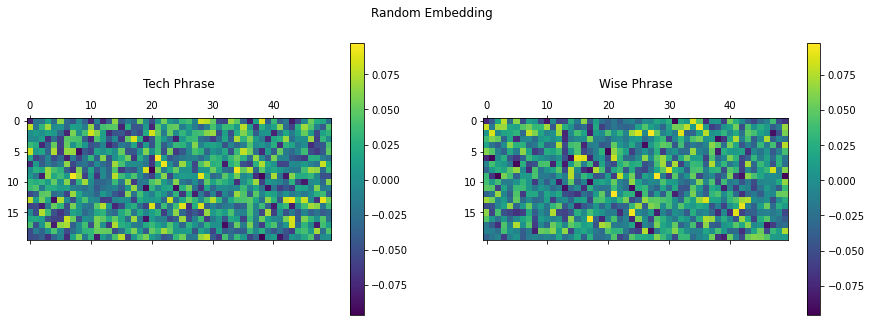

In [15]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

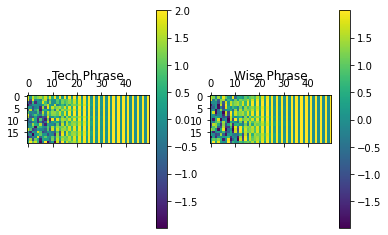

In [16]:
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()